## Merging of Per-Core Logs
### Can we assume the following about per-core behavior: 
#### If all cores of a running experiment do similar work, then their individual behaviors - as exposed by their per-core logs - are similar to each other, and hence, the behavior of all cores can be merged into an overall behavior of the full experimental run.

In [1]:
import os
import time
import pandas as pd
import numpy as np

In [2]:
import eigen_analysis

cols = eigen_analysis.LINUX_COLS
time_unit = eigen_analysis.TIME_CONVERSION_khz
joules_unit = eigen_analysis.JOULE_CONVERSION

In [3]:
# get all itrs explored for some (dvfs, qps) pair
def list_itrs(rdtsc_dirname):
    itrs = []
    for file in os.listdir(rdtsc_dirname):
        tags = file.split('_')
        itr = tags[1]
        itrs.append(itr)
    itrs = list(set(itrs))
    return itrs

In [4]:
global itrs

In [5]:
def print_err_log(dvfs, qps, itr, rapl='135', run='0', err_dir = 'err_logs/'):
    err_filename = 'err_log_' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    if os.path.exists(err_dir + err_filename):
        err_file = open(err_dir + err_filename, 'r')
        print(err_file.read())
    else:
        print('EMPTY ERROR LOG')

In [6]:
def handle_neg_diffs(df_diffs, df, core, err_file):
    
    tmp = df_diffs.copy()

    # isolating rows with negative diffs
    tmp_neg = tmp[(tmp['joules_diff'] < 0) | (tmp['instructions_diff'] < 0) | (tmp['cycles_diff'] < 0) \
                   | (tmp['ref_cycles_diff'] < 0) | (tmp['llc_miss_diff'] < 0) | (tmp['timestamp_diff'] < 0)]

    # re-computing diffs if possible; else dropping rows
    for i,j in tmp_neg.iterrows():
        prev = df.shift(1).loc[i]
        cur = df.loc[i]
        # TODO note that we are only handling case of RAPL-energy-status register overflow
        if (tmp.loc[i]['joules_diff'] < 0) & (tmp.loc[i]['timestamp_diff'] >= 0.001):
            err_file.write('CORE ' + str(core) + '  ---  JOULES COUNTER OVERFLOW AT LOG ENTRY DIFF #' + str(i) + '\n')
            tmp.loc[i, ['joules_diff']] = (2**32 - 1) * joules_unit - prev['joules'] + cur['joules'] 
        else:
            err_file.write('CORE ' + str(core) + '  ---  UNEXPLAINED NEGATIVE VALS AT LOG ENTRY DIFF # ' + str(i) + '\n')
            cols = ''
            prevs = ''
            currs = ''
            for col in list(df.columns):
                cols += col + '  '
                prevs += str(prev[col]) + '  '
                currs += str(cur[col]) + '  '
            err_file.write('          ' + cols + '\n')
            err_file.write('         log[' + str(i-1) + ']: ' + prevs + '\n')
            err_file.write('         log[' + str(i) + ']: ' + currs + '\n')
            tmp = tmp.drop(i, axis=0)

    return tmp

In [8]:
# given (dvfs, qps, itr), concatenate all per-core logs into one big dataframe
def concat_core_logs(dvfs, qps, itr, rapl='135', run='0'):
    print('Concatenating all per-core logs with ITR-DELAY = ', itr)
    
    # here are all the log files for this dvfs & qps
    logs_dir = qps + '_qps/linux_mcd_dmesg_' + run + '_' + dvfs + '_' + rapl + '_' + qps + '/'
    # here are all the time-management files for this dvfs & qps
    rdtsc_dir = qps + '_qps/linux_mcd_rdtsc_' + run + '_' + dvfs + '_' + rapl + '_' + qps +'/'
    rdtsc_file = rdtsc_dir + 'linux.mcd.rdtsc.' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    start, end = eigen_analysis.get_rdtsc(rdtsc_file)
        
    # initializing error log file
    err_dir = 'err_logs/'
    err_filename = 'err_log_' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    err_file = open(err_dir + err_filename, 'w')

    # here will be stored counter-based log data from all cores
    counters_full_df = pd.DataFrame()
    # here will be stored non-counter-based log data from all cores
    non_counters_full_df = pd.DataFrame()
    
    # TODO remove fixed core-id range
    for c in range(0,16):
        file = logs_dir + 'linux.mcd.dmesg.' + run + '_' + str(c) + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
        df = pd.read_csv(file, sep = ' ', names = cols, index_col='i')
        df = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]
        df['timestamp'] = df['timestamp'] - df['timestamp'].min()
        df['timestamp'] = df['timestamp'] * time_unit
        df['joules'] = df['joules'] * joules_unit

        # CONCATENATING MILLISECOND-LEVEL PER-CORE DFS
        ##############################################
        # removing zero-filled log-entries
        # -> these represent interrupt occurrences at a frequency greater than per-1ms
        counters_df = df[['joules', 'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'timestamp']].copy()
        counters_df = counters_df[(counters_df['joules'] > 0) & (counters_df['instructions'] > 0) \
                                            & (counters_df['cycles'] > 0) & (counters_df['ref_cycles'] > 0) \
                                            & (counters_df['llc_miss'] > 0)]

        # SCHEME 1: merge per-core logs on index i where
        #           i = order of occurrence of a log-entry in a per-core log
#        df_diffs = df_diffs.drop(['timestamp_diff'], axis=1).reset_index()
#        if counters_full_df.shape[0] == 0:
#            counters_full_df = df_diffs.copy()
#        else:
#            counters_full_df = counters_full_df.merge(df_diffs, left_index=True, right_index=True, \
#                                                      how='outer', sort=True, suffixes=('', '_0')).fillna(0)

        # SCHEME 2
        tmp = counters_df['timestamp']        
        # computing diffs of counter readings
        df_diffs = counters_df.diff().dropna().copy()
        df_diffs.columns = [f'{c}_diff' for c in df_diffs.columns]
        df_diffs = handle_neg_diffs(df_diffs, counters_df, c, err_file)
        df_diffs = df_diffs.drop(['timestamp_diff'], axis=1)
        df_diffs['timestamp'] = tmp

        if counters_full_df.shape[0] == 0:
            counters_full_df = df_diffs.copy()
        else:
            counters_full_df = counters_full_df.merge(df_diffs, \
                                                      left_on = 'timestamp', \
                                                      right_on = 'timestamp', \
                                                      how='outer', \
                                                      sort=True, \
                                                      suffixes=('', '_0')).fillna(0)        

        # CONCATENATING MICROSECOND-LEVEL PER-CORE DFS
        ##############################################
        non_counters_df = df[['rx_bytes', 'rx_desc', 'tx_bytes', 'tx_desc', 'timestamp']].copy()                                                          

        # SCHEME 1
#        if non_counters_full_df.shape[0] == 0:
#            non_counters_full_df = non_counters_df.copy()
#        else:
#            non_counters_full_df = non_counters_full_df.merge(non_counters_df, left_index=True, right_index=True, \
#                                                              how='outer', sort=True, suffixes=('', '_0')).fillna(0)
        # SCHEME 2
        if non_counters_full_df.shape[0] == 0:
            non_counters_full_df = non_counters_df.copy()
        else:
            non_counters_full_df = non_counters_full_df.merge(non_counters_df, \
                                                              left_on = 'timestamp', \
                                                              right_on = 'timestamp', \
                                                              how='outer', \
                                                              sort=True, \
                                                              suffixes=('', '_0')).fillna(0)                           

        print('CORE: ', str(c))
        print('         NON COUNTERS:  full =', non_counters_df.shape[0], \
              '  expected:', int(20 * 10**6 / int(itr)))        
        print('         COUNTERS:      full =', counters_df.shape[0], \
              '  after computing diffs =', df_diffs.shape[0]          \
             )

    # delete error log if empty
    err_file.close()
    if (os.path.getsize(err_dir + err_filename) == 0):
        os.remove(err_dir + err_filename)
        
    print()
    print('-------------------------------------------------- PARSED 16 LOGS -------------------------')
    print()
    return counters_full_df, non_counters_full_df

In [9]:
def merge_concat_logs(counters_full_df, non_counters_full_df):
    
    # creating dfs of average per-core log readings
    df_merged_counter = pd.DataFrame(columns=['instructions_diff', 'cycles_diff', 'ref_cycles_diff', \
                                     'llc_miss_diff', 'joules_diff'])
    df_merged_non_counter = pd.DataFrame(columns=['rx_bytes', 'rx_desc', 'tx_bytes', 'tx_desc'])

    # SCHEME 1
#    for col in df_merged_counter.columns:
#        df_merged_counter[col] = (counters_full_df[[col, col+'_0']].sum(axis=1))/16
#    for col in df_merged_non_counter.columns:
#        df_merged_non_counter[col] = (non_counters_full_df[[col, col+'_0']].sum(axis=1))/16

    # SCHEME 2
    for col in df_merged_counter.columns:
        df_merged_counter[col] = (counters_full_df[[col, col+'_0']].sum(axis=1))
    df_merged_counter['timestamp'] = counters_full_df['timestamp']
    for col in df_merged_non_counter.columns:
        df_merged_non_counter[col] = (non_counters_full_df[[col, col+'_0']].sum(axis=1))
    df_merged_non_counter['timestamp'] = non_counters_full_df['timestamp']
    
    return df_merged_counter, df_merged_non_counter

In [10]:
def save_merged_logs(merged_counters_df, merged_non_counters_df, dvfs, qps, itr, rapl='135', run='0'):
    
    counters_df_outdir = qps + '_' + dvfs + '_counters_merged/'
    non_counters_df_outdir = qps + '_' + dvfs + '_non_counters_merged/'
    !mkdir -p $counters_df_outdir
    !mkdir -p $non_counters_df_outdir
    counters_outfile = counters_df_outdir + dvfs + '_' + qps + '_' + itr + '_counters_merged'
    non_counters_outfile = non_counters_df_outdir + dvfs + '_' + qps + '_' + itr + '_non_counters_merged'
    merged_counters_df.to_csv(counters_outfile)
    merged_non_counters_df.to_csv(non_counters_outfile)

    print('COUNTERS DIR: ')
    !ls $counters_df_outdir
    print('NON_COUNTERS DIR: ')
    !ls $non_counters_df_outdir

In [11]:
dvfs = '0xd00'
qps = '200k'
run = '0'
rapl = '135'
itrs = list_itrs(qps + '_qps/linux_mcd_rdtsc_' + run + '_' + dvfs + '_' + rapl + '_' + qps +'/')
for itr in ['100', '200', '250', '300', '350', '400']:
    counters_full_df = pd.DataFrame()
    non_counters_full_df = pd.DataFrame()
    counters_full_df, non_counters_full_df = concat_core_logs(dvfs, qps, itr)
    print_err_log(dvfs, qps, itr)
    merged_counters_df, merged_non_counters_df = merge_concat_logs(counters_full_df, non_counters_full_df)
    save_merged_logs(merged_counters_df, merged_non_counters_df, dvfs, qps, itr)
    print('----------------------------------------')

Concatenating all per-core logs with ITR-DELAY =  100
CORE:  0
         NON COUNTERS:  full = 189076   expected: 200000
         COUNTERS:      full = 19250   after computing diffs = 19249
CORE:  1
         NON COUNTERS:  full = 188392   expected: 200000
         COUNTERS:      full = 19235   after computing diffs = 19234
CORE:  2
         NON COUNTERS:  full = 189058   expected: 200000
         COUNTERS:      full = 19254   after computing diffs = 19253
CORE:  3
         NON COUNTERS:  full = 188296   expected: 200000
         COUNTERS:      full = 19236   after computing diffs = 19235
CORE:  4
         NON COUNTERS:  full = 188894   expected: 200000
         COUNTERS:      full = 19241   after computing diffs = 19240
CORE:  5
         NON COUNTERS:  full = 188378   expected: 200000
         COUNTERS:      full = 19242   after computing diffs = 19241
CORE:  6
         NON COUNTERS:  full = 189017   expected: 200000
         COUNTERS:      full = 19256   after computing diffs = 19255
C

CORE:  2
         NON COUNTERS:  full = 65105   expected: 66666
         COUNTERS:      full = 16280   after computing diffs = 16279
CORE:  3
         NON COUNTERS:  full = 65096   expected: 66666
         COUNTERS:      full = 16280   after computing diffs = 16279
CORE:  4
         NON COUNTERS:  full = 65108   expected: 66666
         COUNTERS:      full = 16280   after computing diffs = 16279
CORE:  5
         NON COUNTERS:  full = 65094   expected: 66666
         COUNTERS:      full = 16278   after computing diffs = 16277
CORE:  6
         NON COUNTERS:  full = 65104   expected: 66666
         COUNTERS:      full = 16280   after computing diffs = 16279
CORE:  7
         NON COUNTERS:  full = 65071   expected: 66666
         COUNTERS:      full = 16280   after computing diffs = 16279
CORE:  8
         NON COUNTERS:  full = 65100   expected: 66666
         COUNTERS:      full = 16280   after computing diffs = 16279
CORE:  9
         NON COUNTERS:  full = 65091   expected: 66666
     

----------------------------------------


In [191]:
counters_full_df

,joules_diff,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff,timestamp,joules_diff_0,instructions_diff_0,cycles_diff_0,ref_cycles_diff_0,...,joules_diff_0,instructions_diff_0,cycles_diff_0,ref_cycles_diff_0,llc_miss_diff_0,joules_diff_0,instructions_diff_0,cycles_diff_0,ref_cycles_diff_0,llc_miss_diff_0
0,0.000000,0.0,0.0,0.0,0.0,0.001013,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.001039,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.001179,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.001180,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.001181,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312521,0.000000,0.0,0.0,0.0,0.0,20.004909,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312522,0.000000,0.0,0.0,0.0,0.0,20.005042,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312523,0.000000,0.0,0.0,0.0,0.0,20.005092,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312524,0.120658,403771.0,823330.0,1842660.0,2311.0,20.005166,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [192]:
non_counters_full_df

,rx_bytes,rx_desc,tx_bytes,tx_desc,timestamp,rx_bytes_0,rx_desc_0,tx_bytes_0,tx_desc_0,rx_bytes_0,...,tx_bytes_0,tx_desc_0,rx_bytes_0,rx_desc_0,tx_bytes_0,tx_desc_0,rx_bytes_0,rx_desc_0,tx_bytes_0,tx_desc_0
0,66.0,1.0,74.0,2.0,0.000000,66.0,1.0,74.0,2.0,66.0,...,74.0,2.0,66.0,1.0,74.0,2.0,66.0,1.0,74.0,2.0
1,0.0,0.0,0.0,0.0,0.000156,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000159,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000160,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000163,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562652,66.0,1.0,0.0,0.0,20.005166,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1562653,0.0,0.0,0.0,0.0,20.005168,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,66.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1562654,0.0,0.0,0.0,0.0,20.005174,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1562655,0.0,0.0,0.0,0.0,20.005184,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [193]:
merged_counters_df

,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff,joules_diff,timestamp
0,574832.0,1236903.0,2759263.0,3688.0,0.106811,0.001013
1,610133.0,1290368.0,2878540.0,4075.0,0.096563,0.001039
2,741428.0,1454321.0,3244288.0,4609.0,0.096563,0.001179
3,683487.0,1471062.0,3281582.0,4465.0,0.096563,0.001180
4,644647.0,1429929.0,3189855.0,4408.0,0.096563,0.001181
...,...,...,...,...,...,...
312521,268199.0,574765.0,1283627.0,1644.0,0.120658,20.004909
312522,231737.0,523483.0,1167743.0,1719.0,0.124623,20.005042
312523,408515.0,859902.0,1920148.0,2220.0,0.120658,20.005092
312524,403771.0,823330.0,1842660.0,2311.0,0.120658,20.005166


In [194]:
merged_non_counters_df

,rx_bytes,rx_desc,tx_bytes,tx_desc,timestamp
0,1122.0,17.0,1258.0,34.0,0.000000
1,391.0,3.0,0.0,0.0,0.000156
2,396.0,3.0,0.0,0.0,0.000159
3,257.0,2.0,0.0,0.0,0.000160
4,223.0,1.0,0.0,0.0,0.000163
...,...,...,...,...,...
1562652,66.0,1.0,0.0,0.0,20.005166
1562653,66.0,1.0,0.0,0.0,20.005168
1562654,66.0,1.0,0.0,0.0,20.005174
1562655,66.0,1.0,0.0,0.0,20.005184


### Correlation matrices and eigenvals:

In [29]:
def per_core_corr(dvfs, qps, itr, rapl='135', run='0'):

    counters_corr_dict = {}
    non_counters_corr_dict = {}

    # here are all the log files for this dvfs & qps
    logs_dir = qps + '_qps/linux_mcd_dmesg_' + run + '_' + dvfs + '_' + rapl + '_' + qps + '/'
    # here are all the time-management files for this dvfs & qps
    rdtsc_dir = qps + '_qps/linux_mcd_rdtsc_' + run + '_' + dvfs + '_' + rapl + '_' + qps +'/'
    rdtsc_file = rdtsc_dir + 'linux.mcd.rdtsc.' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    start, end = eigen_analysis.get_rdtsc(rdtsc_file)

    # initializing error log file
    err_dir = 'err_logs/'
    err_filename = 'err_log_' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    err_file = open(err_dir + err_filename, 'w')

    # TODO remove fixed core-id range
    for c in range(0,16):
        file = logs_dir + 'linux.mcd.dmesg.' + run + '_' + str(c) + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
        df = pd.read_csv(file, sep = ' ', names = cols, index_col='i')
        df = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]
        df['timestamp'] = df['timestamp'] - df['timestamp'].min()
        df['timestamp'] = df['timestamp'] * time_unit
        df['joules'] = df['joules'] * joules_unit
        counters_df = df[['joules', 'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'timestamp']].copy()
        counters_df = counters_df[(counters_df['joules'] > 0) & (counters_df['instructions'] > 0) \
                                            & (counters_df['cycles'] > 0) & (counters_df['ref_cycles'] > 0) \
                                            & (counters_df['llc_miss'] > 0)]
        # computing diffs of counter readings
#        df_diffs = counters_df.diff().dropna().copy()
#        df_diffs.columns = [f'{c}_diff' for c in df_diffs.columns]
#        df_diffs = handle_neg_diffs(df_diffs, counters_df, c, err_file)
#        df_corr = df_diffs.drop(['timestamp_diff'], axis = 1).corr()
        df_corr = counters_df.drop(['timestamp'], axis=1).corr()
        counters_corr_dict[str(c)] = df_corr

        non_counters_df = df[['rx_bytes', 'rx_desc', 'tx_bytes', 'tx_desc']].copy()
        df_corr = non_counters_df.corr()
        non_counters_corr_dict[str(c)] = df_corr
        
    return counters_corr_dict, non_counters_corr_dict

In [24]:
from numpy.linalg import eig, eigvalsh

def get_eig_vals(counters_corr_dict, non_counters_corr_dict, merged_counters_df, merged_non_counters_df):
    all_core_eigvals = {}
    
    for c in range(0,16):
        counter_vals, vecs = eig(counters_corr_dict[str(c)])
        non_counter_vals, vecs = eig(non_counters_corr_dict[str(c)])
        all_core_eigvals[str(c)] = np.concatenate([counter_vals , non_counter_vals])

    merged_corr = merged_counters_df.drop(['timestamp'], axis = 1).corr()
    merged_counter_vals, merged_vecs = eig(merged_corr)
    merged_corr = merged_non_counters_df.drop(['timestamp'], axis = 1).corr()
    merged_non_counter_vals, merged_vecs = eig(merged_corr)
    all_core_eigvals['merged'] = np.concatenate([merged_counter_vals, merged_non_counter_vals])
    
    return all_core_eigvals

In [227]:
import matplotlib.pyplot as plt

def plot_eig_vals(eig_dict, itr='200'):
    plt.figure(figsize=(10,6))
    num_eig = len(list(eig_dict.values())[0])
    eig_list = [str(i) for i in range(0, num_eig)]
    for core in eig_dict.keys():
        vals = eig_dict[core]
        #print(vals)
        plt.plot(eig_list, vals, 'p')
    plt.plot(eig_list, eig_dict['merged'], 'x')    
    plt.xlabel('eig_id')
    plt.ylabel('eig_val')
    plt.title(f'Eigenvals of Corr Matrices of {len(eig_dict.keys())} mcd Cores for ITR-DELAY {itr}')

In [201]:
counters_corr_dict, non_counters_corr_dict = per_core_corr(dvfs, qps, '200')

In [202]:
counters_corr_dict['0']

,joules_diff,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
joules_diff,1.000000,0.024349,0.038408,0.038393,0.038174
instructions_diff,0.024349,1.000000,0.897574,0.897634,0.613366
cycles_diff,0.038408,0.897574,1.000000,0.999995,0.772671
ref_cycles_diff,0.038393,0.897634,0.999995,1.000000,0.772628
llc_miss_diff,0.038174,0.613366,0.772671,0.772628,1.000000


In [203]:
non_counters_corr_dict['0']

,rx_bytes,rx_desc,tx_bytes,tx_desc
rx_bytes,1.000000,0.699087,0.003185,0.003549
rx_desc,0.699087,1.000000,0.025790,0.017999
tx_bytes,0.003185,0.025790,1.000000,0.549814
tx_desc,0.003549,0.017999,0.549814,1.000000


In [204]:
merged_counters_df.drop(['timestamp'], axis = 1).corr()

,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff,joules_diff
instructions_diff,1.000000,0.870412,0.870429,0.618973,0.020301
cycles_diff,0.870412,1.000000,0.999994,0.761397,0.032496
ref_cycles_diff,0.870429,0.999994,1.000000,0.761342,0.032460
llc_miss_diff,0.618973,0.761397,0.761342,1.000000,0.028559
joules_diff,0.020301,0.032496,0.032460,0.028559,1.000000


In [205]:
merged_non_counters_df.drop(['timestamp'], axis = 1).corr()

,rx_bytes,rx_desc,tx_bytes,tx_desc
rx_bytes,1.000000,0.696760,0.009350,0.010268
rx_desc,0.696760,1.000000,0.028293,0.024222
tx_bytes,0.009350,0.028293,1.000000,0.575762
tx_desc,0.010268,0.024222,0.575762,1.000000


In [225]:
eig_vals = get_eig_vals(counters_corr_dict, non_counters_corr_dict, merged_counters_df, merged_non_counters_df)

In [226]:
eig_vals

{'0': array([3.49283505e+00, 9.98286647e-01, 4.08038999e-01, 1.00834497e-01,
        4.80884217e-06, 1.70326312e+00, 1.54592418e+00, 3.00527070e-01,
        4.50285630e-01]),
 '1': array([3.45546435e+00, 9.98842204e-01, 3.85654230e-01, 1.60036429e-01,
        2.79137700e-06, 1.70571913e+00, 1.57663358e+00, 3.05628488e-01,
        4.12018804e-01]),
 '2': array([3.49126506e+00, 9.98882156e-01, 4.07425207e-01, 1.02422412e-01,
        5.15936009e-06, 1.70983994e+00, 1.55589993e+00, 2.97494944e-01,
        4.36765186e-01]),
 '3': array([3.43525825e+00, 9.98699452e-01, 4.03873332e-01, 1.62161291e-01,
        7.67311943e-06, 1.70898136e+00, 1.58359910e+00, 3.02234244e-01,
        4.05185300e-01]),
 '4': array([3.46467198e+00, 9.98635430e-01, 4.25309318e-01, 1.11374161e-01,
        9.10884949e-06, 1.70288555e+00, 1.55805734e+00, 3.00578489e-01,
        4.38478621e-01]),
 '5': array([3.46072461e+00, 9.98602744e-01, 3.81387194e-01, 1.59279538e-01,
        5.91209008e-06, 1.69748624e+00, 1.580725

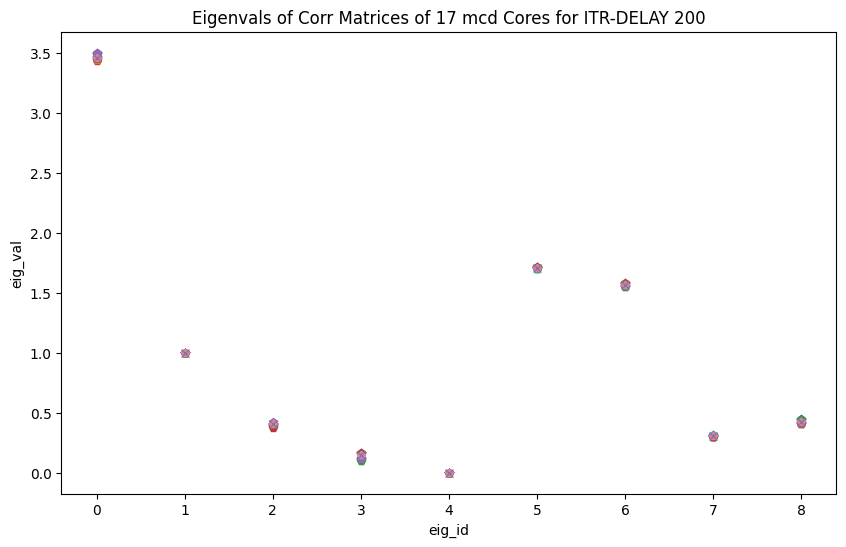

In [228]:
plot_eig_vals(eig_vals)

### Looking at correlation matrices and eigenvals of counterwithout computing diffs

In [19]:
dvfs = '0xd00'
qps = '400k'
run = '0'
rapl = '135'
itrs = list_itrs(qps + '_qps/linux_mcd_rdtsc_' + run + '_' + dvfs + '_' + rapl + '_' + qps +'/')
#for itr in itrs:
for itr in ['200']:
    counters_full_df = pd.DataFrame()
    non_counters_full_df = pd.DataFrame()
    counters_full_df, non_counters_full_df = concat_core_logs(dvfs, qps, itr)
    print_err_log(dvfs, qps, itr)
    merged_counters_df, merged_non_counters_df = merge_concat_logs(counters_full_df, non_counters_full_df)
    #save_merged_logs(merged_counters_df, merged_non_counters_df, dvfs, qps, itr)
    print('----------------------------------------')

Concatenating all per-core logs with ITR-DELAY =  200
CORE:  0
         NON COUNTERS:  full = 97674   expected: 100000
         COUNTERS:      full = 19535
CORE:  1
         NON COUNTERS:  full = 97660   expected: 100000
         COUNTERS:      full = 19532
CORE:  2
         NON COUNTERS:  full = 97672   expected: 100000
         COUNTERS:      full = 19534
CORE:  3
         NON COUNTERS:  full = 97663   expected: 100000
         COUNTERS:      full = 19533
CORE:  4
         NON COUNTERS:  full = 97670   expected: 100000
         COUNTERS:      full = 19535
CORE:  5
         NON COUNTERS:  full = 97663   expected: 100000
         COUNTERS:      full = 19533
CORE:  6
         NON COUNTERS:  full = 97675   expected: 100000
         COUNTERS:      full = 19534
CORE:  7
         NON COUNTERS:  full = 97666   expected: 100000
         COUNTERS:      full = 19534
CORE:  8
         NON COUNTERS:  full = 97672   expected: 100000
         COUNTERS:      full = 19535
CORE:  9
         NON COUNTE

In [20]:
counters_full_df

,joules,instructions,cycles,ref_cycles,llc_miss,timestamp,joules_0,instructions_0,cycles_0,ref_cycles_0,...,joules_0,instructions_0,cycles_0,ref_cycles_0,llc_miss_0,joules_0,instructions_0,cycles_0,ref_cycles_0,llc_miss_0
0,112594.473867,7.709393e+12,1.347138e+13,1.946304e+13,2.628190e+10,0.000000,144061.283729,7.847966e+12,1.362528e+13,1.961674e+13,...,112594.473867,7.710670e+12,1.344741e+13,1.941218e+13,2.641859e+10,144061.283729,7.866446e+12,1.357385e+13,1.956172e+13,2.805357e+10
1,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000792,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.001013,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.001039,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.001179,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312523,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,20.004909,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
312524,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,20.005042,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
312525,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,20.005092,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
312526,114988.026576,7.719295e+12,1.348903e+13,1.950242e+13,2.631454e+10,20.005166,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [32]:
merged_counters_df.drop(['timestamp'], axis=1).corr()

,instructions,cycles,ref_cycles,llc_miss,joules
instructions,1.000000,0.970050,0.958751,0.865703,0.576706
cycles,0.970050,1.000000,0.998383,0.757710,0.414586
ref_cycles,0.958751,0.998383,1.000000,0.721268,0.365671
llc_miss,0.865703,0.757710,0.721268,1.000000,0.901450
joules,0.576706,0.414586,0.365671,0.901450,1.000000


In [30]:
counters_corr_dict, non_counters_corr_dict = per_core_corr(dvfs, qps, '200')

In [33]:
counters_corr_dict['10']

,joules,instructions,cycles,ref_cycles,llc_miss
joules,1.000000,0.999994,0.999982,0.999982,0.999626
instructions,0.999994,1.000000,0.999990,0.999990,0.999644
cycles,0.999982,0.999990,1.000000,1.000000,0.999751
ref_cycles,0.999982,0.999990,1.000000,1.000000,0.999751
llc_miss,0.999626,0.999644,0.999751,0.999751,1.000000


In [34]:
eig_vals = get_eig_vals(counters_corr_dict, non_counters_corr_dict, merged_counters_df, merged_non_counters_df)

In [35]:
eig_vals

{'0': array([4.99928757e+00, 7.04828121e-04, 6.25334205e-06, 1.34635111e-06,
        1.46665602e-11, 1.70326312e+00, 1.54592418e+00, 3.00527070e-01,
        4.50285630e-01]),
 '1': array([4.99952193e+00, 4.67650259e-04, 7.33358492e-06, 3.08274644e-06,
        5.32936920e-11, 1.70571913e+00, 1.57663358e+00, 3.05628488e-01,
        4.12018804e-01]),
 '2': array([4.99916459e+00, 8.30195575e-04, 3.73907147e-06, 1.47977848e-06,
        3.36320207e-11, 1.70983994e+00, 1.55589993e+00, 2.97494944e-01,
        4.36765186e-01]),
 '3': array([4.99949643e+00, 4.92313174e-04, 9.27728725e-06, 1.97538342e-06,
        1.17158806e-10, 1.70898136e+00, 1.58359910e+00, 3.02234244e-01,
        4.05185300e-01]),
 '4': array([4.99927886e+00, 7.06653265e-04, 1.25084391e-05, 1.98049143e-06,
        2.23419125e-10, 1.70288555e+00, 1.55805734e+00, 3.00578489e-01,
        4.38478621e-01]),
 '5': array([4.99948229e+00, 5.11536664e-04, 5.03637544e-06, 1.14021451e-06,
        1.72508328e-10, 1.69748624e+00, 1.580725